In [45]:
import pandas as pd
from IPython.display import HTML, display, clear_output, FileLink
from tqdm.auto import tqdm
import time
pd.set_option('max_columns', None)

from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
from multiprocessing import Pool
import re
from better_profanity import profanity

In [54]:
comments_csv = './data/all_petitions_comments_20211112-095033.csv'
search_csv = './data/change_org_petitions_Amber_Heard_at_20211005-222550_limit_1000_offset_0_delay_ms_500.csv'
milestones_csv = './data/all_petitions_milestones_20211112-093758.csv'
petitions = pd.read_csv(search_csv)
comments = pd.read_csv(comments_csv)

In [55]:
comments

,index,id,comment,parent_id,children_count,commentable_type,commentable_id,likes,role,created_at,deleted_at,user.id,user.slug,user.first_name,user.last_name,user.short_display_name,user.display_name,user.city,user.state_code,user.country_code,user.website,user.locale,user.description,user.photo.id,user.photo.url,user.photo.sizes.small.url,user.photo.sizes.small.processing,user.photo.sizes.small.size.width,user.photo.sizes.small.size.height,user.photo.sizes.medium.url,user.photo.sizes.medium.processing,user.photo.sizes.medium.size.width,user.photo.sizes.medium.size.height,user.photo.sizes.large.url,user.photo.sizes.large.processing,user.photo.sizes.large.size.width,user.photo.sizes.large.size.height,user.photo.sizes.xlarge.url,user.photo.sizes.xlarge.processing,user.photo.sizes.xlarge.size.width,user.photo.sizes.xlarge.size.height,user.roles,commentable_entity.slug,petition__slug,status_manual
0,0,810211260,"Johnny Depp is Innocent, Amber Heard is a lier...",0,0,Event,14986339,1,comment,2020-12-07T02:33:21Z,NaN,577958717,577958717,Cesar,Ramirez,Cesar,Cesar Ramirez,Santa Ana,CA,US,NaN,en-US,NaN,145246649.0,photos/7/uq/dv/QVuqDvrhjPwmlbz-fullsize.jpg,//assets.change.org/photos/7/uq/dv/QVuqDvrhjPw...,False,48.0,48.0,//assets.change.org/photos/7/uq/dv/QVuqDvrhjPw...,False,128.0,128.0,//assets.change.org/photos/7/uq/dv/QVuqDvrhjPw...,False,400.0,400.0,//assets.change.org/photos/7/uq/dv/QVuqDvrhjPw...,False,800.0,800.0,[],warner-brothers-save-johnny-depp-as-gellert-gr...,warner-brothers-save-johnny-depp-as-gellert-gr...,against
1,1,809954316,She's an evil abuser. Justice for JD! She shou...,0,0,Event,14986339,0,comment,2020-12-01T19:45:00Z,NaN,1166768300,1166768300,Brandi,Granger,Brandi,Brandi Granger,Missouri City,TX,US,NaN,en-US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],warner-brothers-save-johnny-depp-as-gellert-gr...,warner-brothers-save-johnny-depp-as-gellert-gr...,against
2,2,809039707,The contradictions were endless from Amber. Is...,0,0,Event,14986339,0,comment,2020-11-10T17:14:31Z,NaN,1163496852,1163496852,Ishan,Sam,Ishan,Ishan Sam,Kadawatha,NaN,LK,NaN,en-GB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],warner-brothers-save-johnny-depp-as-gellert-gr...,warner-brothers-save-johnny-depp-as-gellert-gr...,against
3,3,808992235,"Я подписываю эту петицию, потому что Джонни ве...",0,0,Event,14986339,0,comment,2020-11-10T00:54:56Z,NaN,1163312015,1163312015,Даша,Дейнега,Даша,Даша Дейнега,NaN,NaN,UA,NaN,ru-RU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],warner-brothers-save-johnny-depp-as-gellert-gr...,warner-brothers-save-johnny-depp-as-gellert-gr...,against
4,4,808898141,Justice4johnny now,0,0,Event,14986339,0,comment,2020-11-08T15:03:27Z,NaN,1115721022,1115721022,Nicole,Hill,Nicole,Nicole Hill,Wasaga Beach,NaN,CA,NaN,en-CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],warner-brothers-save-johnny-depp-as-gellert-gr...,warner-brothers-save-johnny-depp-as-gellert-gr...,against
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27233,26,808862945,Amber Herd committed assault. She deserves to ...,0,0,Event,25706549,0,comment,2020-11-07T23:26:11Z,NaN,736666730,736666730,Glenn,Davie,Glenn,Glenn Davie,NaN,NaN,AU,NaN,en-GB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],warner-bros-pictures-justice-for-depp,warner-bros-pictures-justice-for-depp_limit_1,against
27234,27,808842947,he deserves justice.,0,0,Event,25706549,0,comment,2020-11-07T16:28:43Z,NaN,794759026,794759026,Shaniqua,Phillips,Shaniqua,Shaniqua Phillips,NaN,NaN,US,NaN,en-US,NaN,199354321.0,photos/7/xp/tb/NmXpTBqUNdhLCOg-fullsize.jpg,//assets.change.org/photos/7/xp/tb/NmXpTBqUNdh...,False,48.0,48.0,//assets.change.org/photos/7/xp/tb/NmXpTBqUNdh...,False,128.0,128.0,//assets.change.or

In [56]:
petition_by_slug = {
    p._source__slug: p for _, p in petitions.iterrows()
}

In [57]:
comments = comments[comments['status_manual'] == 'against']
comments = comments.sort_values(by=['status_manual', 'commentable_entity.slug', 'created_at'],
                                       ascending=[True, True, False])

In [58]:
def preprocess_comment(c):
    # removing HTML tags
    c = BeautifulSoup(c, "lxml").text
    
    # replacing newlines with a space
    c = c.replace("\n", " ")
    
    # removing non-alphanumeric characters
    c = re.sub(r'[^A-Za-z0-9. ]+', ' ', c)
    
    # replacing multiple spaces with a single one
    c = ' '.join(c.split())
    
    # to lowercase
    c = c.lower()
    
    return c

def map_parallel(array, fcn):
    with Pool(4) as p:
        array_out = list(tqdm(p.imap(fcn, array), total=len(array)))
        
    return array_out

comments_processed = map_parallel(comments.comment, preprocess_comment)

In [95]:
def sensitive(c):
    mention = 'amber heard' in c
    
    if not mention: return False
    
    def threats(c):
        # https://relatedwords.io/suicide
        lst = ['die', 'kill', 'suicide', 'sick', 'ill', 'death', 'murder', 'gun', 'homicide', 'illness', 'dead']
        c_set = set(c.split())
        return any([z in c_set for z in lst])

    return threats(c) or profanity.contains_profanity(c)

In [ ]:
comments_select = map_parallel(comments_processed, sensitive)

In [97]:
import numpy as np
np.mean(comments_select)

0.00018652540476012832

In [50]:
comments = comments.iloc[comments_select]

In [36]:
len(comments)

5

(array([2., 0., 1., 0., 0., 0., 0., 1., 0., 1.]),
 array([ 28. ,  60.1,  92.2, 124.3, 156.4, 188.5, 220.6, 252.7, 284.8,
        316.9, 349. ]),
 <BarContainer object of 10 artists>)

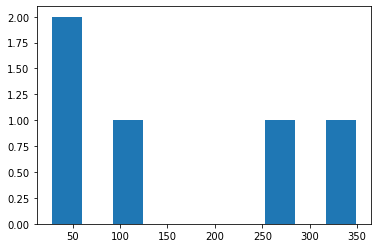

In [46]:
plt.hist([len(t) for t in comments.comment])

In [37]:
def comment_to_html(comment):
    # petition = petition_by_slug.get(comment['commentable_entity.slug'], {})
    nl = "\n"
    # petition.get('_source__ask')
    html = f"""
    <p>
    <b>{comment['user.display_name']}</b> from
        <b>{comment['user.country_code']}</b> {comment['user.state_code']} on <b>{comment.created_at}</b> ({comment.likes} likes):
    <blockquote>{comment.comment.replace(nl, '<br />')}</blockquote>
    </p>
    """
    return html

In [38]:
display(HTML(comment_to_html(comments.iloc[0])))

In [39]:
petition_htmls = ""
for petition_slug, comments_by_p in tqdm(comments.groupby('commentable_entity.slug')):
    slug = petition_slug
    petition = petition_by_slug.get(slug, {})
    htmls = [comment_to_html(c) for _, c in tqdm(comments_by_p.iterrows(), leave=False)]
    petition_desc = f"{petition.get('_source__ask', 'N/A')} ({slug}) {petition.get('_source__total_signature_count', '?')} signatures"
    petition_htmls += f"<center><h4>{petition_desc}</h4></center>{''.join(htmls)}<hr />"

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [40]:
all_html = '<html><head><meta charset="utf-8"><title>All comments</title></head><body>'
all_html += petition_htmls
all_html += '</body></html>'

In [41]:
out_html = comments_csv + '.select.html'
with open(out_html, 'w') as f:
    f.write(all_html)

In [42]:
FileLink(out_html)

/home/sergia/worldie/data/all_petitions_comments_20211112-095033.csv.select1.html

In [43]:
out_pdf = out_html + '.pdf'
!wkhtmltopdf {out_html} {out_pdf}
FileLink(out_pdf)

Loading page (1/2)
Printing pages (2/2)                                               
Done                                                           


/home/sergia/worldie/data/all_petitions_comments_20211112-095033.csv.select1.html.pdf